In [ ]:
!pip install gdal
!pip install fiona
!pip install geopandas

In [ ]:
import cv2 as cv
import fiona
from shapely.geometry import mapping, MultiPolygon, Polygon, Point

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cannyOverlay_SUM.tif to cannyOverlay_SUM.tif


In [ ]:
from osgeo import gdal
ds = gdal.Open('/content/cannyOverlay_SUM.tif')
width = ds.RasterXSize
height = ds.RasterYSize
GT = ds.GetGeoTransform()


In [ ]:
GT

(-121.50307105804048,
 8.983152841195215e-05,
 0.0,
 38.2049897074896,
 0.0,
 -8.983152841195215e-05)

In [ ]:
img = cv.imread('cannyOverlay_SUM.tif',cv.IMREAD_UNCHANGED)

In [ ]:
img_n = cv.normalize(src=img, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)

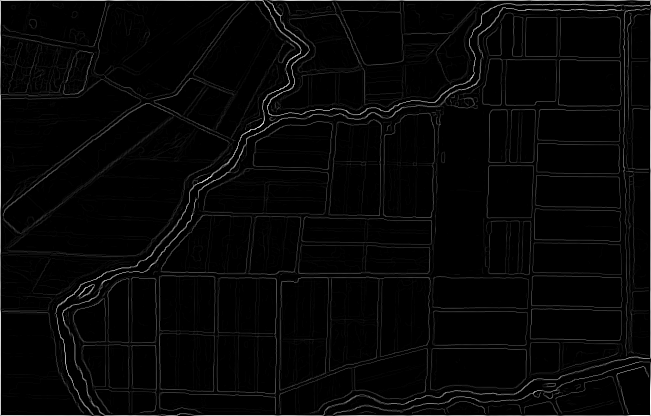

In [ ]:
from google.colab.patches import cv_imshow
cv_imshow(img_n)

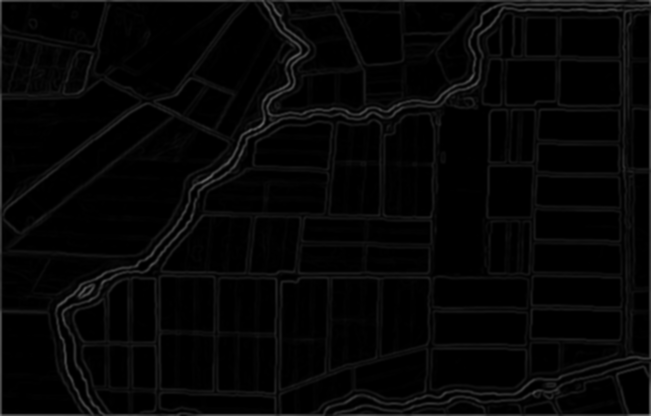

In [ ]:
img_blur = cv.GaussianBlur(img_n,(5,5),0)
cv_imshow(img_blur)

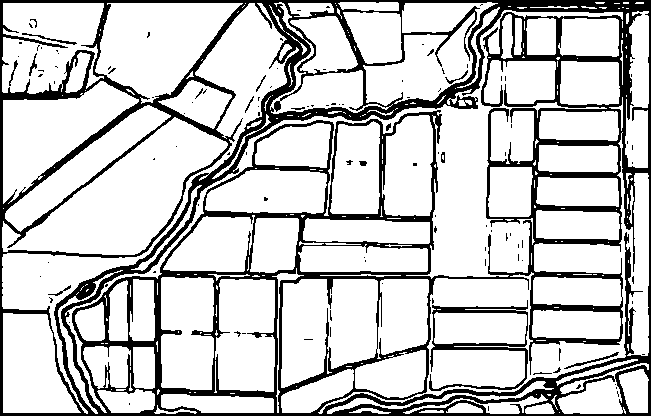

In [ ]:
thresh = 10
maxValue = 255 
th, dst = cv.threshold(img_blur, 10, maxValue, cv.THRESH_BINARY_INV)
cv_imshow(dst)

In [ ]:
from collections import defaultdict
def mask_to_polygons(mask, epsilon=10., min_area=10.):
    """Convert a mask ndarray (binarized image) to Multipolygons"""
    # first, find contours with cv2: it's much faster than shapely
    contours, hierarchy = cv.findContours(mask,
                                  cv.RETR_CCOMP,
                                  cv.CHAIN_APPROX_NONE)
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    # http://docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(contours):
        if idx not in child_contours and cv.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv.contourArea(c) >= min_area])
            all_polygons.append(poly)
    all_polygons = MultiPolygon(all_polygons)

    return all_polygons

In [ ]:
poly = mask_to_polygons(dst)

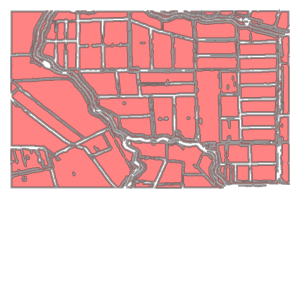

In [ ]:
poly

In [ ]:
multipolygon1=[]
for i in poly:
  points=[]
  # print(i)
  for j in np.array(i.exterior):
    # print(j)
    x = j[0]
    y = j[1]
    Xgeo = GT[0] + x*GT[1] + y*GT[2]
    Ygeo = GT[3] + x*GT[4] + y*GT[5]
    # print(Xgeo, Ygeo)
    poly_point = Point(Xgeo, Ygeo)
    # print('1',poly_point)
    points.append(poly_point)
    # print('2',points)
    
  polygon_1 = Polygon(points)
  multipolygon1.append(polygon_1)


multipolygon2 = MultiPolygon(multipolygon1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
for i in list(points):
  print(i)

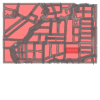

In [ ]:
multipolygon2

In [ ]:
for i in multipolygon2:
  print(i)

In [ ]:
crs = from_epsg(4326)

# Here's an example Shapely geometry
# poly = Polygon([(0, 0), (0, 1), (1, 1), (0, 0)])
poly = multipolygon2

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon', 
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('my_shp2.shp', 'w', 'ESRI Shapefile', schema, crs=crs) as c:
    ## If there are multiple geometries, put the "for" loop here
    for index, i in enumerate(poly):
      c.write({
          'geometry': mapping(i),
          'properties': {'id': index},
    })

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  app.launch_new_instance()


In [ ]:
import geopandas as gpd
nReserve = gpd.read_file('my_shp2.shp') 
nReserve

,id,geometry
0,0,"POLYGON ((-121.46462 38.24182, -121.46471 38.2..."
1,1,"POLYGON ((-121.47055 38.24164, -121.47064 38.2..."
2,2,"POLYGON ((-121.48897 38.24164, -121.48897 38.2..."
3,3,"POLYGON ((-121.45429 38.24128, -121.45438 38.2..."
4,4,"POLYGON ((-121.46301 38.24128, -121.46310 38.2..."
...,...,...
146,146,"POLYGON ((-121.47720 38.20526, -121.47711 38.2..."
147,147,"POLYGON ((-121.47989 38.20526, -121.47980 38.2..."
148,148,"POLYGON ((-121.48061 38.20526, -121.48070 38.2..."
149,149,"POLYGON ((-121.49310 38.20526, -121.49301 38.2..."
